## Importing Libraries 

In [56]:
import numpy as np
import pandas as pd 

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup

from os import walk
from os.path import join

import matplotlib.pyplot as plt 
from wordcloud import WordCloud
from PIL import Image
import seaborn as sns

#Other 
%matplotlib inline
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shubhamghag/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shubhamghag/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Constants

In [57]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'


SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE ='SpamData/02_Training/train-data.txt'
TESTING_DATA_FILE ='SpamData/02_Training/test-data.txt'

TOKEN_SPAM_PROB_FILE ='SpamData/03_Testing/prob-spam.txt'
TOKEN_NORM_PROB_FILE ='SpamData/03_Testing/prob-norm.txt'
TOKEN_ALL_PROB_FILE ='SpamData/03_Testing/prob-all-tokens.txt'

TEST_FEATURE_MATRIX ='SpamData/03_Testing/test-features.txt'
TEST_TARGET_FILE = 'SpamData/03_Testing/test-target.txt'


LIKE_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
UNLIKE_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

## Reading Files 

In [58]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [59]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False 
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)





Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator Function

In [60]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [61]:
for i in generate_squares(5):
    print(i, end=' -> ')

0 -> 1 -> 4 -> 9 -> 16 -> 

## Email Body Extraction

In [62]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False 
            lines = []
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body 

        

In [63]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [64]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [65]:
spam_emails.shape

(1898, 2)

In [66]:
non_spam_emails = df_from_directory(EASY_NONSPAM_1_PATH,HAM_CAT)
non_spam_emails = non_spam_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
non_spam_emails.head()

,MESSAGE,CATEGORY
00769.25bf9a767b5db0ed93f03c1637281663,"\n\nIn a message dated 9/24/2002 11:24:58 AM, ...",0
01074.8590d61ac0aeeadb58dc2f2ba776c406,"Hiya, I always seem to get errors when I do an...",0
02479.14365bcad3a60fcf24c5c1813f6291fb,\n\nI don't know how one can expect better and...,0
01417.ce7b07a2114218dbac682b599785820d,Tim Peters wrote:\n\n> I've run no experiments...,0
00357.d559b71616f64ba1d1c1e61a03644fd4,"At 10:34 AM -0700 on 8/28/02, Jim Whitehead wr...",0


In [67]:
non_spam_emails.shape

(3901, 2)

In [68]:
df = pd.concat([spam_emails, non_spam_emails])
print("Shape of the entire dataframe is:", df.shape)
df.head()

Shape of the entire dataframe is: (5799, 2)


,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


## Data Cleaning 

In [69]:
df['MESSAGE'].isnull().sum()

0

In [70]:
(df.MESSAGE.str.len() == 0).sum()

3

In [71]:
df[df.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [72]:
df.drop(['cmds'], inplace=True)

In [73]:
(df.MESSAGE.str.len() == 0).sum()

0

In [74]:
df.shape

(5796, 2)

## Adding Document IDs to Track Emails in DF 

In [75]:
doc_ids = range(0, len(df.index))
df['DOC_IDS'] = doc_ids

In [76]:
df['FILE_NAME'] = df.index
df.set_index('DOC_IDS', inplace = True)
df.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_IDS,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
2,This is a multi-part message in MIME format.\n...,1,00214.1367039e50dc6b7adb0f2aa8aba83216
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
4,This is the bottom line. If you can GIVE AWAY...,1,00033.9babb58d9298daa2963d4f514193d7d6


In [77]:
df.to_json(DATA_JSON_FILE)

## EDA

In [78]:
df.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [79]:
total_spam = df.CATEGORY.value_counts()[1]
total_non_spam = df.CATEGORY.value_counts()[0]

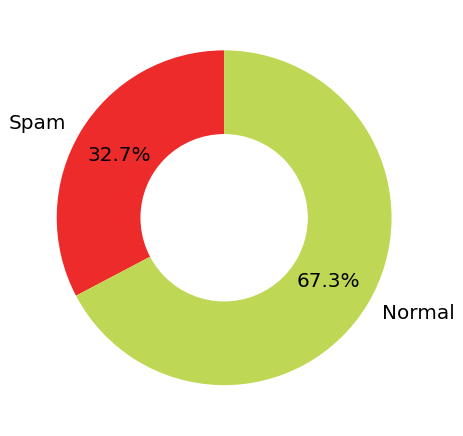

In [80]:
category_names = ['Spam', 'Normal']
sizes = [total_spam,total_non_spam]

custom_colors = ['#ED2B2A', '#BED754']

plt.figure(figsize=(6,8),dpi=90)
plt.pie(sizes, labels=category_names, textprops={'fontsize':16},startangle=90
    ,autopct='%1.1f%%', colors=custom_colors,pctdistance=0.73)

centre_circle = plt.Circle((0,0),radius=0.5,fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

## Preprocessing the data for analysis
### Word Stemming 

In [81]:
stemmer = PorterStemmer()

In [82]:
soup = BeautifulSoup(df.at[2,'MESSAGE'], 'html.parser')
print(soup.get_text())

This is a multi-part message in MIME format.



------=_NextPart_000_1CDC19_01C25366.4B57F3A0

Content-Type: text/plain;

	charset="Windows-1252"

Content-Transfer-Encoding: quoted-printable



 We dare you...

 Try to find a better annuity!

=20

  - 5.40% Guaranteed for 6 Years=0A=

- 6 Year Surrender Charge=0A=

- 5% Agent

Commission up to age 80=09

Call today for more information!

 800-888-7641 ext. 103

- or -



Please fill out the form below for more information	=20

Name:	 	  =09

E-mail:	 	=20

Phone:	 	=20

City:	 	 State:	 	=20

 	    =09

=20

 PMG Financial Services

*5.40% for deposits of $100,000 and up, 5.25% interest for deposits

totalling $25,000-$99,999.	=20

We don't want anyone to receive our mailings who does not wish to

receive them. This is a professional communication sent to insurance

professionals. To be removed from this mailing list, DO NOT REPLY to

this message. Instead, go here: http://www.insuranceiq.com/optout

=20



Legal Notice =20



------=_

In [83]:
def clean_emails(email,stemmer=PorterStemmer()
                ,stop_words=set(stopwords.words('english'))):
    soup = BeautifulSoup(email,'html.parser')
    cleaned = soup.get_text()
    
    words = word_tokenize(cleaned.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            #filtered_words.append(word)
    return filtered_words

In [84]:
clean_emails(df.at[2,'MESSAGE'])

['messag',
 'mime',
 'format',
 'dare',
 'tri',
 'find',
 'better',
 'annuiti',
 'guarante',
 'year',
 'surrend',
 'agent',
 'commiss',
 'age',
 'call',
 'today',
 'inform',
 'ext',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'pmg',
 'financi',
 'servic',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'commun',
 'sent',
 'insur',
 'profession',
 'remov',
 'mail',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic',
 'dare',
 'find',
 'better',
 'annuiti',
 'call',
 'today',
 'inform',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'sent',
 'insur',
 'profession',
 'remov',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic']

In [85]:
%%time

nested_list = df.MESSAGE.apply(clean_emails)

/var/folders/dw/g0x_cwzj4l97vv535grtx42w0000gn/T/ipykernel_4929/2575873531.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(email,'html.parser')
/var/folders/dw/g0x_cwzj4l97vv535grtx42w0000gn/T/ipykernel_4929/2575873531.py:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(email,'html.parser')


CPU times: user 27.4 s, sys: 378 ms, total: 27.8 s
Wall time: 28.3 s


In [86]:
nested_list.head()

DOC_IDS
0    [dear, homeown, interest, rate, lowest, point,...
1    [attent, must, comput, user, packag, deal, nor...
2    [messag, mime, format, dare, tri, find, better...
3    [import, inform, new, domain, name, final, ava...
4    [bottom, line, give, away, cd, free, peopl, li...
Name: MESSAGE, dtype: object

In [87]:
nested_list.tail()

DOC_IDS
5791    [one, work, well, week, te, updat, server, syn...
5792    [damien, morton, quot, approv, html, abl, say,...
5793    [mon, che, wrote, that, correct, line, ad, rep...
5794    [upon, time, manfr, wrote, would, like, instal...
5795    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, dtype: object

In [88]:
doc_ids_spam = df[df.CATEGORY == 1].index
doc_ids_normal = df[df.CATEGORY == 0].index

doc_ids_normal

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_IDS', length=3900)

In [89]:
nested_list_normal = nested_list.loc[doc_ids_normal]
nested_list_normal.head()

DOC_IDS
1896    [messag, date, jamesr, write, situat, would, h...
1897    [hiya, alway, seem, get, error, apt, updat, pr...
1898    [know, one, expect, better, secur, code, commu...
1899    [tim, peter, wrote, run, experi, train, set, s...
1900    [jim, whitehead, wrote, great, half, need, bec...
Name: MESSAGE, dtype: object

In [90]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_spam.head()

DOC_IDS
0    [dear, homeown, interest, rate, lowest, point,...
1    [attent, must, comput, user, packag, deal, nor...
2    [messag, mime, format, dare, tri, find, better...
3    [import, inform, new, domain, name, final, ava...
4    [bottom, line, give, away, cd, free, peopl, li...
Name: MESSAGE, dtype: object

In [91]:
flat_list_normal = [item for sublist in nested_list_normal for item in sublist]
normal_words = pd.Series(flat_list_normal)
unique_words = pd.Series(flat_list_normal).value_counts()

print('Total number of words in normal emails:', normal_words.shape[0])
print('Total number of unique words in normal emails:', unique_words.shape[0])

Total number of words in normal emails: 442056
Total number of unique words in normal emails: 20815


In [92]:
print('Most Common words:',unique_words[:10])

Most Common words: http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64


In [93]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spam_words = pd.Series(flat_list_spam)
unique_words = pd.Series(flat_list_spam).value_counts()

print('Total number of words in spam emails:', spam_words.shape[0])
print('Total number of unique words in spam emails:', unique_words.shape[0])

Total number of words in spam emails: 317502
Total number of unique words in spam emails: 13242


In [94]:
print('Most Common words:',unique_words[:10])

Most Common words: http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64


### Word Clouds

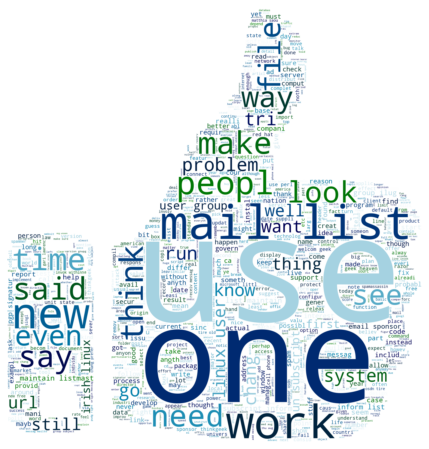

CPU times: user 13.1 s, sys: 518 ms, total: 13.7 s
Wall time: 13.3 s


In [95]:
%%time

img = Image.open(LIKE_FILE)
img_mask = Image.new(mode='RGB', size=img.size, color=(255, 255, 255))
img_mask.paste(img, box=img)

rgb_array = np.array(img_mask)

# Assuming flat_list_normal is a pre-processed list of words
normal_str = ' '.join(flat_list_normal)

# You can adjust the max_words parameter here to a suitable value
word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=1000, colormap='ocean')

# The generate function may still raise an error if normal_str is too long
try:
    word_cloud.generate(normal_str)
except ValueError as e:
    print("String too long, try reducing the number of words or splitting the string")

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

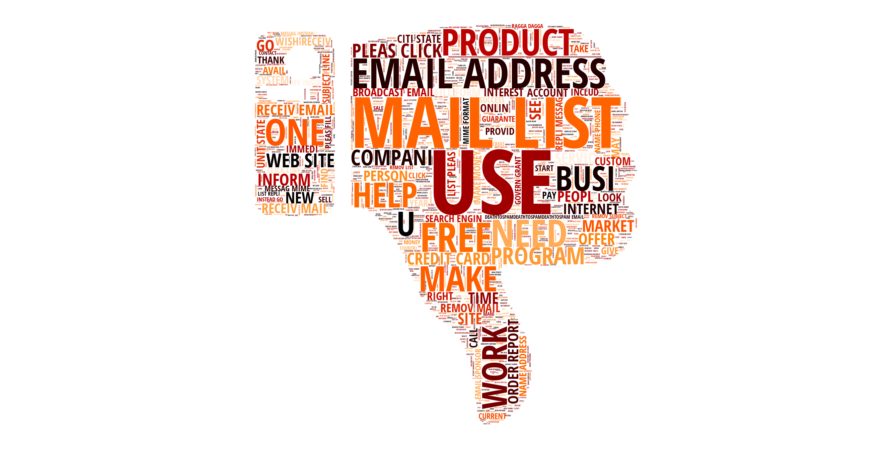

CPU times: user 25.7 s, sys: 984 ms, total: 26.6 s
Wall time: 26.7 s


In [96]:
%%time

img = Image.open(UNLIKE_FILE)
img_mask = Image.new(mode='RGB', size=img.size, color=(255, 255, 255))
img_mask.paste(img, box=img)

rgb_array = np.array(img_mask)

# Assuming flat_list_normal is a pre-processed list of words
spam_str = ' '.join(flat_list_spam)

# You can adjust the max_words parameter here to a suitable value
word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=2000, colormap='gist_heat',font_path=CUSTOM_FONT_FILE)

# The generate function may still raise an error if normal_str is too long
try:
    word_cloud.generate(spam_str.upper())
except ValueError as e:
    print("String too long, try reducing the number of words or splitting the string")

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [97]:
stemmed_nested_list = df.MESSAGE.apply(clean_emails)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

/var/folders/dw/g0x_cwzj4l97vv535grtx42w0000gn/T/ipykernel_4929/2575873531.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(email,'html.parser')
/var/folders/dw/g0x_cwzj4l97vv535grtx42w0000gn/T/ipykernel_4929/2575873531.py:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(email,'html.parser')


In [98]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words', unique_words.shape[0])
unique_words.head()

Number of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [99]:
frequent_words = unique_words[0:VOCAB_SIZE]
print("Most common words: \n", frequent_words[:10])

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


In [100]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


In [101]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

In [102]:
df_word_columns = pd.DataFrame.from_records(stemmed_nested_list.tolist())
df_word_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,dear,homeown,interest,rate,lowest,point,year,help,find,best,...,None,None,None,None,None,None,None,None,None,None
1,attent,must,comput,user,packag,deal,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,dare,tri,find,better,annuiti,guarante,year,...,None,None,None,None,None,None,None,None,None,None
3,import,inform,new,domain,name,final,avail,gener,public,discount,...,None,None,None,None,None,None,None,None,None,None
4,bottom,line,give,away,cd,free,peopl,like,one,month,...,None,None,None,None,None,None,None,None,None,None


## Train-Test split

In [103]:
X_train, X_test, y_train, y_test = train_test_split(df_word_columns, df.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [104]:
print("Number of training samples", X_train.shape[0])
print("Percentage of training set", np.round((X_train.shape[0] / df_word_columns.shape[0]) * 100),"%")

Number of training samples 4057
Percentage of training set 70.0 %


In [105]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,thu,jul,rodent,unusu,size,wrote,appli,one,three,order,...,None,None,None,None,None,None,None,None,None,None
4727,well,would,vaniti,list,forward,least,littl,pure,data,week,...,None,None,None,None,None,None,None,None,None,None
5022,world,wide,word,issu,saturday,august,sent,saturday,subscrib,least,...,None,None,None,None,None,None,None,None,None,None
3504,believ,spamassassin,maintain,scheme,wherebi,corpu,distribut,ie,sever,peopl,...,None,None,None,None,None,None,None,None,None,None
3921,sorri,think,send,realiz,list,sender,usual,anyawi,ask,harri,...,None,None,None,None,None,None,None,None,None,None


In [106]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [107]:
def make_sparse_matrix(df, indexed_words, labels):
    
    nr_rows = df.shape[0]
    nr_col = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_col):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
            
                dict_list.append(item)
            
    return pd.DataFrame(dict_list)
    
    

In [108]:
%%time 

sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 7min 7s, sys: 4.32 s, total: 7min 11s
Wall time: 7min 17s


In [109]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,393
1,0,4844,1,492
2,0,4844,1,2371
3,0,4844,1,497
4,0,4844,1,37


In [110]:
sparse_train_df.shape

(444950, 4)

In [111]:
sparse_train_df.tail()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
444945,1,860,1,126
444946,1,860,1,644
444947,1,860,1,515
444948,1,860,1,1388
444949,1,860,1,1074


In [112]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID','LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1              2
       7       1              1
       16      1              1
       18      1              1
       24      1              1

In [113]:
train_grouped = train_grouped.reset_index()

In [114]:
train_grouped.shape

(265555, 4)

In [115]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [116]:
%%time 

sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 3min 4s, sys: 1.82 s, total: 3min 6s
Wall time: 3min 8s


In [117]:
sparse_test_df.shape

(187657, 4)

In [118]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID','LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,7,1,1
1,8,8,1,1
2,8,12,1,1
3,8,21,1,2
4,8,26,1,1


In [119]:
np.savetxt(TESTING_DATA_FILE, test_grouped, fmt='%d')

## Creating a Sparse Matrix and a Full Matrix

In [120]:
sparse_train_data = np.loadtxt(TRAINING_DATA_FILE, delimiter=' ', dtype=int)

In [121]:
sparse_test_data = np.loadtxt(TESTING_DATA_FILE, delimiter=' ', dtype=int)

In [122]:
sparse_train_data[-5:]

array([[5795, 1846,    0,    1],
       [5795, 1897,    0,    2],
       [5795, 2124,    0,    1],
       [5795, 2278,    0,    1],
       [5795, 2457,    0,    1]])

In [123]:
print("Number of rows in training file", sparse_train_data.shape[0])
print("Number of rows in test file", sparse_test_data.shape[0])

Number of rows in training file 265555
Number of rows in test file 110579


In [124]:
column_names = ['DOC_ID'] + ['CATEGORY'] + list(range(0,VOCAB_SIZE))
column_names[:5]

['DOC_ID', 'CATEGORY', 0, 1, 2]

In [125]:
len(column_names)

2502

In [126]:
index_names = np.unique(sparse_train_data[:,0])
index_names

array([   0,    1,    2, ..., 5791, 5794, 5795])

In [127]:
full_train_data = pd.DataFrame(index=index_names, columns=column_names)
full_train_data.head()

,DOC_ID,CATEGORY,0,1,2,3,4,5,6,7,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
full_train_data.fillna(value=0,inplace=True)
full_train_data.head()

,DOC_ID,CATEGORY,0,1,2,3,4,5,6,7,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
def make_full_matrix(sparse_matrix, nr_words, doc_idx=0, word_idx=1, cat_idx=2, freq_idx=3):
    
    column_names = ['DOC_ID'] + ['CATEGORY'] + list(range(0,VOCAB_SIZE))
    doc_id_names = np.unique(sparse_matrix[:,0])
    full_matrix = pd.DataFrame(index=doc_id_names, columns=column_names)
    full_matrix.fillna(value=0,inplace=True)
    
    for i in range(sparse_matrix.shape[0]):
        doc_nr = sparse_matrix[i][doc_idx]
        word_id = sparse_matrix[i][word_idx]
        label = sparse_matrix[i][cat_idx]
        occurence = sparse_matrix[i][freq_idx]
        
        full_matrix.at[doc_nr,'DOC_ID'] = doc_nr
        full_matrix.at[doc_nr,'CATEGORY'] = label
        full_matrix.at[doc_nr, word_id] = occurence
        
        
    full_matrix.set_index('DOC_ID', inplace=True)    
    return full_matrix



In [130]:
%%time
full_train_data = make_full_matrix(sparse_train_data, VOCAB_SIZE)

CPU times: user 7.54 s, sys: 318 ms, total: 7.85 s
Wall time: 8.11 s


In [131]:
full_train_data.head()

,CATEGORY,0,1,2,3,4,5,6,7,8,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,1,2,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0,1,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,2,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,2,4,2,3,1,...,0,0,0,0,0,0,0,0,0,0


## Training the Naive Bayes Model

In [132]:
prob_spam = full_train_data.CATEGORY.sum() / full_train_data.CATEGORY.size
print("The probabilty of spam is:", prob_spam * 100,"%")

The probabilty of spam is: 31.116093672147482 %


In [133]:
full_train_features = full_train_data.loc[:, full_train_data.columns != 'CATEGORY']
full_train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,2,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,2,4,2,3,1,1,...,0,0,0,0,0,0,0,0,0,0


In [134]:
email_lengths = full_train_features.sum(axis=1)
email_lengths.shape

(4014,)

In [135]:
email_lengths[:5]

DOC_ID
0     50
1     76
2     87
3     76
4    137
dtype: int64

In [136]:
total_wc = email_lengths.sum()
total_wc

444950

In [137]:
spam_lengths = email_lengths[full_train_data.CATEGORY == 1]
spam_lengths.shape

(1249,)

In [138]:
spam_wc = spam_lengths.sum()
spam_wc

193983

In [139]:
normal_lengths = email_lengths[full_train_data.CATEGORY == 0]
normal_lengths.shape

(2765,)

In [140]:
normal_wc = normal_lengths.sum()
normal_wc

250967

In [141]:
print("Average number of words in spam emails {:.0f}".format(spam_wc / spam_lengths.shape[0]))
print("Average number of words in normal emails {:.2f}".format(normal_wc / normal_lengths.shape[0]))

Average number of words in spam emails 155
Average number of words in normal emails 90.77


In [142]:
train_spam_tokens = full_train_features.loc[full_train_data.CATEGORY == 1]
train_spam_tokens.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,2,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,2,4,2,3,1,1,...,0,0,0,0,0,0,0,0,0,0


In [143]:
sum_spam_tokens = train_spam_tokens.sum(axis=0) + 1
sum_spam_tokens.shape

(2500,)

In [144]:
train_normal_tokens = full_train_features.loc[full_train_data.CATEGORY == 0]
train_normal_tokens = train_normal_tokens.sum(axis=0) + 1
train_normal_tokens.shape

(2500,)

## P(Token | Spam) - Probability of a Token Occurs given the email is spam 

In [145]:
prob_token_spam = sum_spam_tokens / (spam_wc + VOCAB_SIZE)
prob_token_spam.sum()

1.0

## P(Token | Normal) - Probability of a Token Occurs given the email is normal

In [146]:
prob_token_normal = train_normal_tokens / (normal_wc + VOCAB_SIZE)
prob_token_normal.sum()

1.0

## P(Token) - Probability that a Token Occurs

In [147]:
prob_tokens_all = full_train_features.sum(axis=0) / total_wc
prob_tokens_all.sum()

1.0

In [148]:
np.savetxt(TOKEN_SPAM_PROB_FILE, prob_token_spam)
np.savetxt(TOKEN_NORM_PROB_FILE, prob_token_normal)
np.savetxt(TOKEN_ALL_PROB_FILE, prob_tokens_all)

In [149]:
sparse_test_data.shape

(110579, 4)

In [150]:
%%time
full_test_data = make_full_matrix(sparse_test_data, nr_words=VOCAB_SIZE)

CPU times: user 3.22 s, sys: 69.4 ms, total: 3.29 s
Wall time: 3.36 s


In [151]:
X_test = full_test_data.loc[:,full_test_data.columns != 'CATEGORY']
y_test = full_test_data.CATEGORY

In [152]:
np.savetxt(TEST_TARGET_FILE, y_test)
np.savetxt(TEST_FEATURE_MATRIX, X_test)

## Load Dataset

In [153]:
X_test = np.loadtxt(TEST_FEATURE_MATRIX, delimiter=' ')
y_test = np.loadtxt(TEST_TARGET_FILE, delimiter=' ')

In [154]:
prob_token_spam = np.loadtxt(TOKEN_SPAM_PROB_FILE, delimiter=' ')
prob_token_normal = np.loadtxt(TOKEN_NORM_PROB_FILE, delimiter=' ')
prob_all_token = np.loadtxt(TOKEN_ALL_PROB_FILE, delimiter=' ')

In [155]:
X_test[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 1., ..., 0., 0., 0.],
       [3., 0., 1., ..., 0., 0., 0.],
       [5., 1., 2., ..., 0., 0., 0.],
       [1., 2., 0., ..., 0., 0., 0.]])

In [156]:
print("shape of the dot product is ", X_test.dot(prob_token_spam).shape)

shape of the dot product is  (1723,)


## Set the Prior

$$P(Spam \, | X) = \frac{P(X \, | Spam \,) \, P(Spam)} {P(X)}$$

In [157]:
PROB_SPAM = 0.3116

In [158]:
np.log(prob_token_spam)

array([ -4.70340091,  -5.31309911,  -4.97899094, ..., -10.24242104,
        -9.35511785, -12.18833119])

## Joint probability in log 

In [161]:
joint_log_spam = X_test.dot(np.log(prob_token_spam)) + np.log(PROB_SPAM)

In [162]:
joint_log_spam[:5]

array([  3.27951575,  15.72867281,  19.563985  , -16.39389827,
        28.65596689])

In [165]:
joint_log_normal = X_test.dot(np.log(prob_token_normal)) + np.log(1-PROB_SPAM)

In [166]:
joint_log_normal[:5]

array([-11.08374063, -40.13430857, -38.4906581 ,  -2.88595309,
       -60.64901471])

In [168]:
joint_log_normal.size

1723

## Checking for the higher joint probabilties

$$P(Spam \, | \, X) \, > \, P(Normal \, | \, X)$$
<br>
<center>OR</center>
<br>
$$P(Spam \, | \, X) \, < \, P(Normal \, | \, X)$$

In [169]:
prediction = joint_log_spam > joint_log_normal

In [170]:
prediction[-5:]

array([False, False, False, False, False])

## Metrics and Evaluation

$$P(X \, | \, Spam) \, P(Spam) \, \neq \, \frac{P(X \, | \, Spam) \, P(Spam)}{P(X)}$$

## Accuracy

In [174]:
correct_docs = (y_test == prediction).sum()
wrong_docs = (X_test.shape[0] - correct_docs)
print("Docs classified correctly", correct_docs)
print("Docs classified incorrectly", wrong_docs)

Docs classified correctly 1673
Docs classified incorrectly 50


In [178]:
mean_correct = correct_docs/len(X_test)
mean

0.9709808473592572

In [179]:
mean_wrong = wrong_docs/len(X_test)
mean_wrong

0.02901915264074289

## Visualising Results

In [249]:
yaxis_label = 'P(X | SPAM)'
xaxis_label = 'P(X | NORMAL)'

linedata = np.linspace(start=-100, stop=1, num=1000)

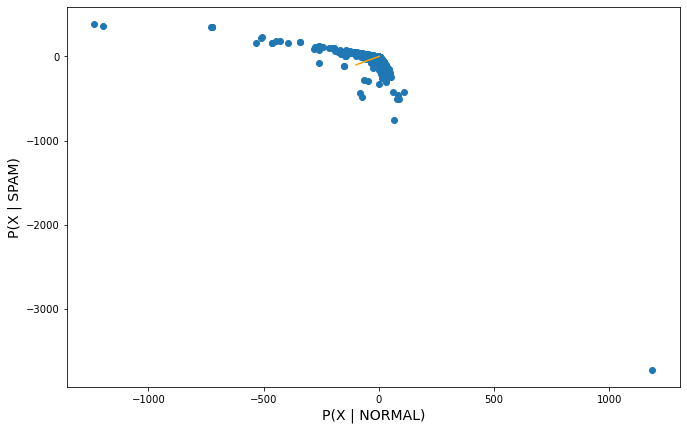

In [254]:
plt.figure(figsize=(11, 7))
plt.xlabel(xaxis_label, fontsize=14)
plt.ylabel(yaxis_label, fontsize=14)

# plt.xlim([-10000,1])
# plt.ylim([-10000,1])

plt.scatter(joint_log_normal, joint_log_spam)
plt.plot(linedata,linedata, color='orange')
plt.show()
